In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Embedding,Input,Dense,LSTM,Bidirectional,GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [3]:
embedding_size = 100
max_vocab_size = 20000
path = 'data/glove.6B.100d.txt'
max_sequence_length = 100
batch_size = 128
epochs = 5
validation_split = .2
filepath_model ="model_weights.hdf5"

In [4]:
def process_embedding_file(path):
    with open(path,encoding='utf-8') as f:
        word2vec = dict()
        for line in f:
            out = line.split()
            word = out[0]
            word2vec[word] = np.asarray(out[1:], dtype='float32')
        return word2vec
            
word2vec = process_embedding_file(path)
            

In [5]:
print('length of word embeddings : {}'.format(len(word2vec)))

length of word embeddings : 400000


In [6]:
df_train = pd.read_csv('data/train.csv')
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
#deleting records with null values
df_train.dropna(inplace=True)
sentences = df_train['comment_text'].values
target = df_train[labels].values

In [7]:
t = Tokenizer(num_words = max_vocab_size)
t.fit_on_texts(sentences)
sequences = t.texts_to_sequences(sentences)
word2idx = t.word_index
print('Number of unique words : {}'.format(len(word2idx)))
padded_sequences = pad_sequences(sequences,maxlen=max_sequence_length)

Number of unique words : 210337


In [8]:
# create weight matrix for words in training sentences
max_vocab_size = min(max_vocab_size,len(word2idx)+1)
embedding_matrix = np.zeros((max_vocab_size,embedding_size))
for word,index in word2idx.items():
    if index < max_vocab_size:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


In [9]:
embedding_layer =Embedding(max_vocab_size,
                           embedding_size,
                           weights=[embedding_matrix],
                           input_length=max_sequence_length,
                           trainable=False)

In [15]:
#building model
input_model = Input(shape=(max_sequence_length,))
x = embedding_layer(input_model)
#rnn = LSTM(15, return_sequences = True)
rnn = Bidirectional(LSTM(15, return_sequences = True))
x = rnn(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(labels),activation='sigmoid')(x)
model =Model(input_model,output)
model.compile(loss = 'binary_crossentropy',optimizer=Adam(lr=.01),metrics=['accuracy'])

In [ ]:
#training model
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(padded_sequences,
                    target,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = validation_split,
                    callbacks=callbacks_list)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 158s 1ms/step - loss: 0.0629 - accuracy: 0.9788 - val_loss: 0.0541 - val_accuracy: 0.9808

Epoch 00001: val_accuracy improved from -inf to 0.98083, saving model to model_weights.hdf5
Epoch 2/5
127656/127656 [==============================] - 165s 1ms/step - loss: 0.0511 - accuracy: 0.9816 - val_loss: 0.0523 - val_accuracy: 0.9814

Epoch 00002: val_accuracy improved from 0.98083 to 0.98141, saving model to model_weights.hdf5
Epoch 3/5
127656/127656 [==============================] - 172s 1ms/step - loss: 0.0488 - accuracy: 0.9823 - val_loss: 0.0504 - val_accuracy: 0.9816

Epoch 00003: val_accuracy improved from 0.98141 to 0.98162, saving model to model_weights.hdf5
Epoch 4/5
127656/127656 [==============================] - 171s 1ms/step - loss: 0.0474 - accuracy: 0.9827 - val_loss: 0.0503 - val_accuracy: 0.9816

Epoch 00004: val_accuracy improved from 0.98162 to 0.98164, saving 

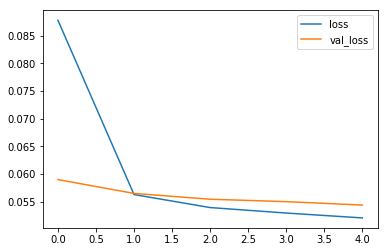

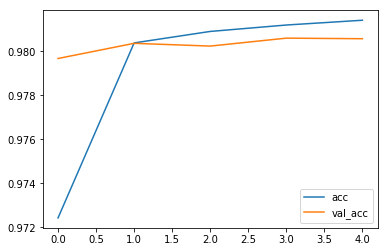

In [13]:
# plot loss data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# plot accuracies  data
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()